In [14]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from geocube.api.core import make_geocube
import rasterio as rio
import scipy.stats as stats
import numpy as np
from datetime import datetime, date
import math
import random
from matplotlib import colors
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [15]:
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [16]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.metrics import confusion_matrix

In [17]:
# Load data
data1722 = pd.read_csv('/users/aleclerc/work/drive/data_portugal_1722_imp.csv')
data0616 = pd.read_csv('/users/aleclerc/work/drive/data_portugal_0616_imp.csv')

In [18]:
# Check the number of fire points
print(data0616['burned_areas'].sum())
print(data1722['burned_areas'].sum())

19065.0
15499.0


In [19]:
# Aim for balanced datasets 
ones_1 = data0616[data0616['burned_areas']==1.0] 
zeros_1 = data0616[data0616['burned_areas']==0]
ones_2 = data1722[data1722['burned_areas']==1.0] 
zeros_2 = data1722[data1722['burned_areas']==0]
sample_1 = zeros_1.sample(n=20000, random_state=13)
sample_2 = zeros_2.sample(n=16000, random_state=13)
data0616 = pd.concat([ones_1, sample_1], ignore_index=True)
data1722 = pd.concat([ones_2, sample_2], ignore_index=True)
print(data0616.shape)
print(data1722.shape)

(39065, 28)
(31499, 28)


In [20]:
# Drop unwanted features 
# Feature dropping in accordance with feature availibilty in the static dataset for susceptibility mapping (comparison) 
unwanted = ['x','y','time','month','population','lc_agriculture','lc_forest','lc_grassland'] 
data_0616 = data0616.drop(columns=unwanted)
data_1722 = data1722.drop(columns=unwanted)

In [21]:
# Get input and output 
input = data_0616.drop('burned_areas', axis=1)
output = data_0616['burned_areas']
X = input
Y = output
unseen_test = data_1722.drop('burned_areas', axis=1)
Y_unseen_test = data_1722['burned_areas']
Y_test = data_1722['burned_areas']

Initiate vertical folds

In [22]:
n_splits = 5 
long_min, long_max = data0616["x"].min(), data0616["x"].max()
intervals = np.linspace(long_min, long_max, n_splits + 1)
data = data0616.sort_values(by="x").reset_index(drop=True)
#data["fold"] = np.digitize(data["x"], intervals) - 1
#print(data["fold"].shape)
Ntotal = len(data["x"])
print(Ntotal)
Nfold = Ntotal/n_splits    # number of data points per fold 
data["fold"] = -1          # initiate folds
print(Nfold)

39065
7813.0


In [23]:
# Create 5 folds with an equal number of data points per fold 
for fold in range(5):
    start = fold*Nfold
    end = start+Nfold if fold<4 else len(data)
    data.loc[start:end - 1, "fold"] = fold  # Assign fold numbers

print(data["fold"].value_counts())

fold
0    7813
1    7813
2    7813
3    7813
4    7813
Name: count, dtype: int64


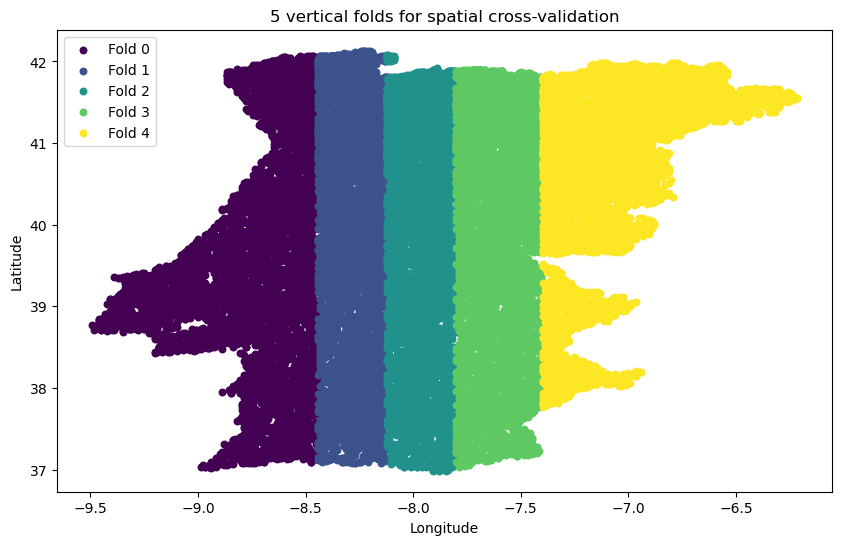

In [24]:
import matplotlib.pyplot as plt

# Define colors for the folds
colors = plt.cm.viridis(np.linspace(0, 1, n_splits))

plt.figure(figsize=(10, 6))

for fold in range(5):
    subset = data[data["fold"] == fold]
    plt.scatter(subset["x"], subset["y"], s=22, color=colors[fold], label=f"Fold {fold}")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("5 vertical folds for spatial cross-validation")
plt.legend()
plt.show()

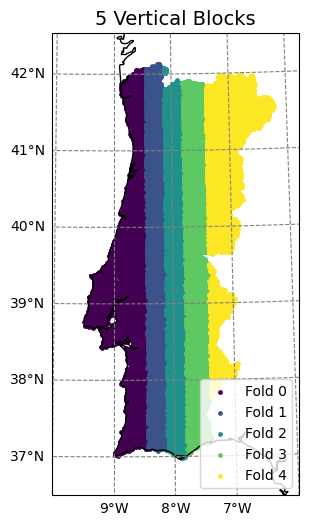

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Define colors for the folds
colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Portugal projection (UTM zone 29N for EPSG:3763)
portugal_proj = ccrs.UTM(zone=29)
data_crs = ccrs.PlateCarree()  # Your data is in (lon, lat)

# Create figure
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=portugal_proj)

# Set extent over Portugal (in degrees, using PlateCarree)
ax.set_extent([-10, -6, 36.5, 42.5], crs=data_crs)

# Add features
ax.coastlines(resolution='10m')
#ax.add_feature(cfeature.BORDERS, linestyle=':')
#ax.add_feature(cfeature.LAND, facecolor='lightgray')
#ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add gridlines and formatted tick labels
gl = ax.gridlines(draw_labels=True, crs=data_crs, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot each fold
for fold in range(5):
    subset = data[data["fold"] == fold]
    ax.scatter(
        subset["x"], subset["y"],
        s=6, color=colors[fold], label=f"Fold {fold}",
        transform=data_crs  # data is in lon/lat
    )
    
# Add North arrow
#ax.text(
    #0.08, 0.20, 'N', transform=ax.transAxes,
    #fontsize=16, fontweight='bold', ha='center', va='center'
#)
#ax.annotate(
    #'', xy=(0.08, 0.18), xytext=(0.08, 0.10),
    #arrowprops=dict(facecolor='black', width=3, headwidth=10),
    #xycoords=ax.transAxes
#)
plt.title("5 Vertical Blocks", fontsize=14)
plt.legend()
plt.show()

fold
0    7813
1    7813
2    7813
3    7813
4    7813
Name: count, dtype: int64


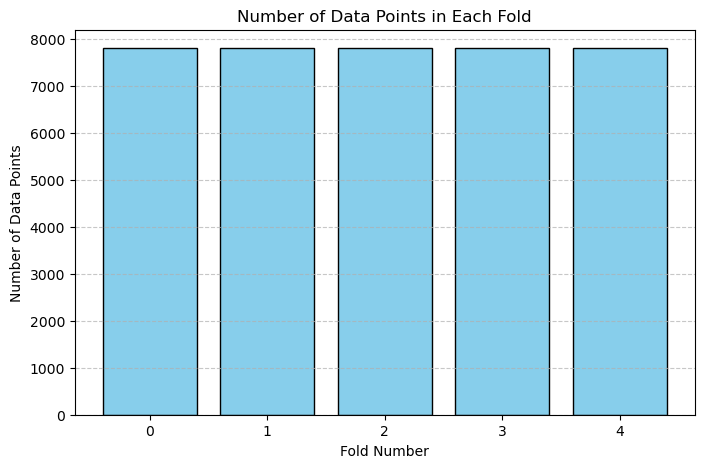

In [26]:
fold_counts = data["fold"].value_counts()  #.sort_index()
print(fold_counts)
plt.figure(figsize=(8, 5))
plt.bar(fold_counts.index, fold_counts.values, color="skyblue", edgecolor="black")

plt.xlabel("Fold Number")
plt.ylabel("Number of Data Points")
plt.title("Number of Data Points in Each Fold")
plt.xticks(range(n_splits))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [27]:
## Create a list that contain all data points in each for to later perform spatial cross-validation
# Empty list to store folds
folds = []

# Convert data indices to a NumPy array for easy indexing
indices = np.arange(len(data))

# Loop over each fold (0 to 4) and create (train, test) splits
for fold in range(5):
    test_indices = data[data["fold"] == fold].index.to_numpy()
    train_indices = np.setdiff1d(indices, test_indices)  # All other indices

    folds.append((train_indices, test_indices))

for i, (train_idx, test_idx) in enumerate(folds):
    print(f"Fold {i}: Train size = {len(train_idx)}, Test size = {len(test_idx)}")

Fold 0: Train size = 31252, Test size = 7813
Fold 1: Train size = 31252, Test size = 7813
Fold 2: Train size = 31252, Test size = 7813
Fold 3: Train size = 31252, Test size = 7813
Fold 4: Train size = 31252, Test size = 7813


In [28]:
from sklearn.utils.class_weight import compute_sample_weight

# Calculate the distribution of the target variable in both training and testing datasets
train_target_dist = output.value_counts(normalize=True)
test_target_dist = Y_test.value_counts(normalize=True)

# Calculate the class weights to adjust for label shift
class_weights = {0: test_target_dist[0] / train_target_dist[0],
                 1: test_target_dist[1] / train_target_dist[1]}
sample_weights = output.map(class_weights)
#sample_weights2 = sample_weights.sample(n=34539, random_state=89) # For best_rf.fit during spatial k-fold cross validation
print(sample_weights.shape)
print(Y_test.shape)
num = X.shape[0]
print(num)
print(sample_weights)

(39065,)
(31499,)
39065
0        1.008226
1        1.008226
2        1.008226
3        1.008226
4        1.008226
           ...   
39060    0.992158
39061    0.992158
39062    0.992158
39063    0.992158
39064    0.992158
Name: burned_areas, Length: 39065, dtype: float64


In [29]:
coordinates = data0616[["x","y"]]
spl_coord = coordinates.sample(n=8623,random_state=89)
fold_labels = -1 * np.ones(len(coordinates), dtype=int)
print(len(coordinates))
print(len(fold_labels))
print(len(test_idx))

39065
39065
7813


In [30]:
# Define the parameter distributions (to be adjusted)
param_dist = {'n_estimators': np.arange(1,100,2),
              'max_depth': np.arange(1,50,1), 'max_features': ['sqrt', 'log2', None, 0.5, 0.75]}

In [31]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from scipy.stats import randint
import pandas as pd
import numpy as np

# Create a random forest classifier
rf = RandomForestClassifier(random_state=13)

# Use RandomizedSearchCV to find the best hyperparameters
rand_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter=5, 
    cv=folds, 
    verbose=1, 
    random_state=13
)

# Fit the randomized search to find the best hyperparameters
rand_search.fit(X, Y, sample_weight=sample_weights)
best_params = rand_search.best_params_

# Get optimized model
best_rf = RandomForestClassifier(**best_params, random_state=13)

# Initialize storage for OOF predictions and true labels
oof_X_test = pd.DataFrame(index=Y.index, columns=X.columns)

oof_proba = pd.Series(index=Y.index, dtype=float)
oof_true = pd.Series(index=Y.index, dtype=Y.dtype)
oof_proba_original = pd.Series(index=Y.index, dtype=Y.dtype)

# List to store performance metrics for each fold
accuracies = []

# Loop through spatial folds
for fold_number, (train_idx, test_idx) in enumerate(folds):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    sample_weights2 = sample_weights.loc[X_train.index]

    # Train best random forest 
    best_rf.fit(X_train, y_train, sample_weight=sample_weights2)

    # Predict on the test set
    y_pred_best_rf = best_rf.predict(X_test)
    y_proba_best_rf = best_rf.predict_proba(X_test)[:,1]

    # Re-instantiate and calibrate the model
    estimator = RandomForestClassifier(**best_params, random_state=13)
    calibrated_rf = CalibratedClassifierCV(
        estimator=estimator,
        method='isotonic',
        cv=3  # internal CV for calibration
    )

    # Fit the calibrated model
    calibrated_rf.fit(X_train, y_train, sample_weight=sample_weights2)

    # Predict probabilities (class 1) using calibrated model
    y_proba = calibrated_rf.predict_proba(X_test)[:, 1]

    # Save calibrated OOF predictions and true labels
    oof_X_test.iloc[test_idx] = X_test
    oof_proba_original.iloc[test_idx] = y_proba_best_rf
    oof_proba.iloc[test_idx] = y_proba
    oof_true.iloc[test_idx] = y_test

    # Predict hard class labels
    y_pred = calibrated_rf.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    print(f"Fold {fold_number+1} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# Calculate and print the average accuracy across folds
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across all folds: {average_accuracy:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fold 1 Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.80      0.89      7813

    accuracy                           0.80      7813
   macro avg       0.50      0.40      0.44      7813
weighted avg       1.00      0.80      0.89      7813

Fold 2 Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.68      0.81      7813

    accuracy                           0.68      7813
   macro avg       0.50      0.34      0.40      7813
weighted avg       1.00      0.68      0.81      7813

Fold 3 Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      4374
         1.0       0.88      0.95      0.92      3439

    accuracy                    

In [32]:
# See which hyperparameters are the best 
print('Best hyperparameters:', best_params)

Best hyperparameters: {'n_estimators': 93, 'max_features': 0.5, 'max_depth': 31}


In [33]:
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(oof_true, oof_proba)

# Compute Youden's J statistic - Derived from the original formula
j_scores = tpr - fpr

# Find threshold with max J
best_thresh = roc_thresholds[np.argmax(j_scores)]

print(f"✅ Best Threshold (Youden's J): {best_thresh:.2f}")

✅ Best Threshold (Youden's J): 0.25


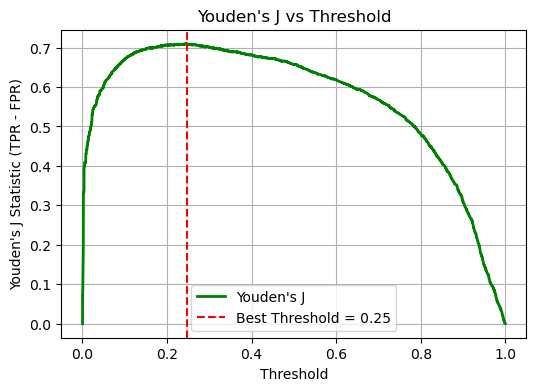

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC and J scores
fpr, tpr, roc_thresholds = roc_curve(oof_true, oof_proba)
j_scores = tpr - fpr

# Find best threshold again (if not already defined)
best_thresh = roc_thresholds[np.argmax(j_scores)]
best_j = j_scores[np.argmax(j_scores)]

# Plot Youden’s J statistic vs threshold
plt.figure(figsize=(6, 4))
plt.plot(roc_thresholds, j_scores, color="green", lw=2, label="Youden's J")
plt.axvline(x=best_thresh, color="red", linestyle="--", label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Youden's J Statistic (TPR - FPR)")
plt.title("Youden's J vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


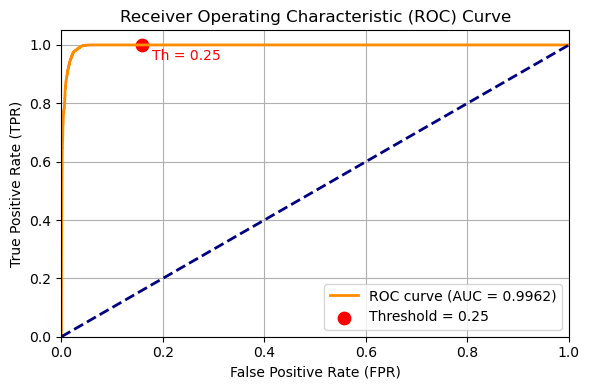

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on full training data 
Y_pred_proba = calibrated_rf.predict_proba(oof_X_test)[:, 1] # oof_X_test

# Compute AUC
auc_value = roc_auc_score(oof_true, Y_pred_proba) # oof_true  
#print(f"AUC: {auc_score:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y, Y_pred_proba)
roc_auc = auc(fpr, tpr)

# Locate point on ROC corresponding to your optimized threshold
threshold_idx = np.argmin(np.abs(thresholds - best_thresh))
fpr_opt = fpr[threshold_idx]
tpr_opt = tpr[threshold_idx]

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate optimized threshold point
plt.scatter(fpr_opt, tpr_opt, color='red', s=80, label=f'Threshold = {best_thresh:.2f}')
plt.text(fpr_opt + 0.02, tpr_opt - 0.05, f'Th = {best_thresh:.2f}', color='red')

# Labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Calibration plot 

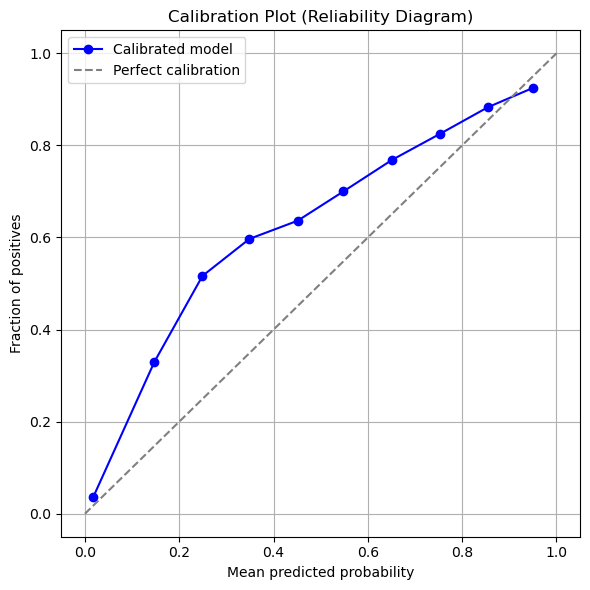

In [36]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Compute calibration curve (reliability diagram)
prob_true, prob_pred = calibration_curve(oof_true, oof_proba, n_bins=10, strategy='uniform')

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated model', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


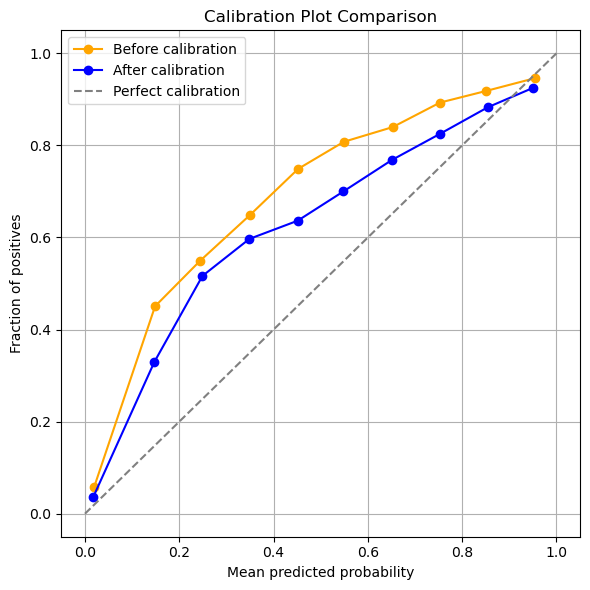

In [37]:
## Compare the curves before and after recalibratiion
# Uncalibrated
prob_true_uncal, prob_pred_uncal = calibration_curve(oof_true, oof_proba_original, n_bins=10)

# Calibrated
prob_true_cal, prob_pred_cal = calibration_curve(oof_true, oof_proba, n_bins=10)

# Plot both
plt.figure(figsize=(6, 6))
plt.plot(prob_pred_uncal, prob_true_uncal, marker='o', label='Before calibration', color='orange')
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='After calibration', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Feature importance 

rh                0.267226
t2m               0.129496
slope             0.088119
sin               0.065832
ssrd              0.057870
dem               0.057060
sp                0.040274
tp                0.039613
wind_direction    0.037400
smi               0.033388
lst_night         0.031057
lst_day           0.028547
cos               0.026983
ndvi              0.025597
wind_speed        0.021853
d2m               0.017857
roads_distance    0.011743
curvature         0.010921
aspect            0.009164
dtype: float64


<Axes: >

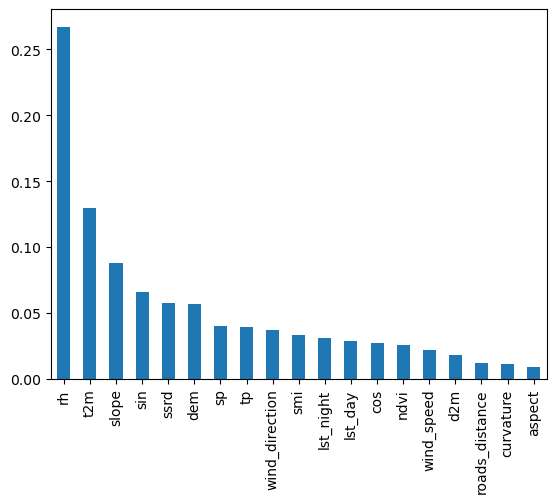

In [38]:
# Feature names of the original dataframe 
feature_names = input.columns

# Convert X_test to DataFrame (if not already a DataFrame)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Now access the columns attribute
feature_imp = pd.Series(best_rf.feature_importances_, index=X_test_df.columns).sort_values(ascending=False)

# Print and plot the feature importance
print(feature_imp)
feature_imp.plot(kind='bar')

Test the model on unseen data

In [39]:
optimal_threshold = 0.25
# Predict on test using optimal threshold
y_test_proba = calibrated_rf.predict_proba(unseen_test)[:, 1]
Y_test_unseen_pred = (y_test_proba >= optimal_threshold).astype(int)

test_accuracy = accuracy_score(Y_unseen_test, Y_test_unseen_pred)
print(test_accuracy)

0.8415187783739166


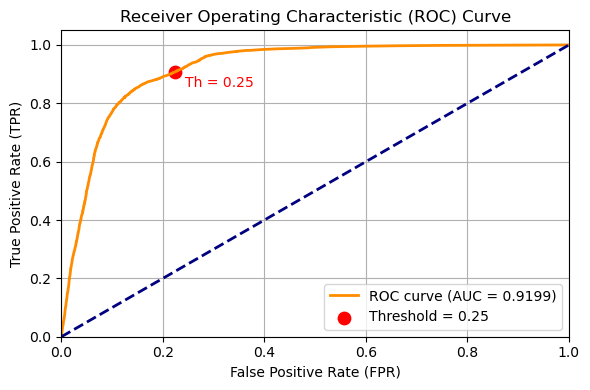

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on full training data 
Y_pred_proba = calibrated_rf.predict_proba(unseen_test)[:, 1]

# Compute AUC
auc_value = roc_auc_score(Y_unseen_test, Y_pred_proba)
#print(f"AUC: {auc_score:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_unseen_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

# Locate point on ROC corresponding to your optimized threshold
threshold_idx = np.argmin(np.abs(thresholds - best_thresh))
fpr_opt = fpr[threshold_idx]
tpr_opt = tpr[threshold_idx]

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate optimized threshold point
plt.scatter(fpr_opt, tpr_opt, color='red', s=80, label=f'Threshold = {best_thresh:.2f}')
plt.text(fpr_opt + 0.02, tpr_opt - 0.05, f'Th = {best_thresh:.2f}', color='red')

# Labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

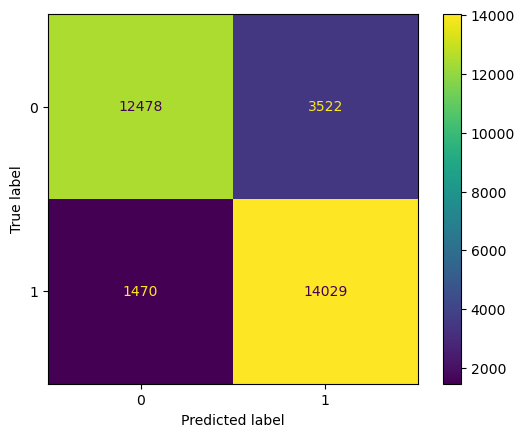

In [41]:
cm = confusion_matrix(Y_unseen_test, Y_test_unseen_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Daily Maps

In [42]:
daily_data = pd.read_csv('/users/aleclerc/work/drive/data_mesogeos_October_13_2017.csv')

In [43]:
# Save coordinates for matching length when plotting 
test_coordinates = daily_data.to_numpy()  # Numpy array already 
longitudes, latitudes = test_coordinates[:, 1], test_coordinates[:, 0]

In [44]:
drop = ['spatial_ref','y','x','time']
daily_data = daily_data.drop(columns=drop)
daily_data = daily_data.to_numpy()

In [45]:
# Transform outputs into probabilities 
proba = calibrated_rf.predict_proba(daily_data)
print(proba) 
susceptibility_map_00 = proba[:, 0]  # Probability of not burning
susceptibility_map_11 = proba[:, 1]  # Probability of burning
print(susceptibility_map_11.shape)

[[0.12345537 0.87654463]
 [0.07897121 0.92102879]
 [0.11080322 0.88919678]
 ...
 [0.76291217 0.23708783]
 [0.7915306  0.2084694 ]
 [0.7915306  0.2084694 ]]
(92202,)


In [46]:
print(susceptibility_map_11.shape)

(92202,)


(7813, 19)


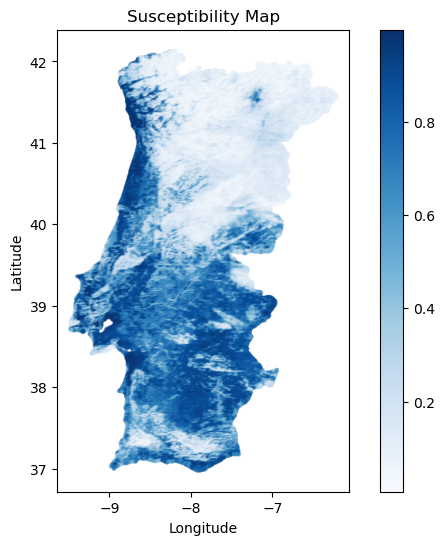

In [47]:
# Plotting 
from shapely.geometry import Point
#test_coordinates = data1722.to_numpy()  # Numpy array already 
#longitudes, latitudes = test_coordinates[:, 2], test_coordinates[:, 1] # 21 and 22  are the coordinatesr indexes 
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(longitudes, latitudes)]
print(X_test.shape)
gdf0 = gpd.GeoDataFrame({'susceptibility': susceptibility_map_00}, geometry=geometry, crs="EPSG:3763")
# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
gdf0.plot(column='susceptibility', cmap='Blues', markersize=4, alpha=0.3, legend=True, ax=ax)
ax.set_title("Susceptibility Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

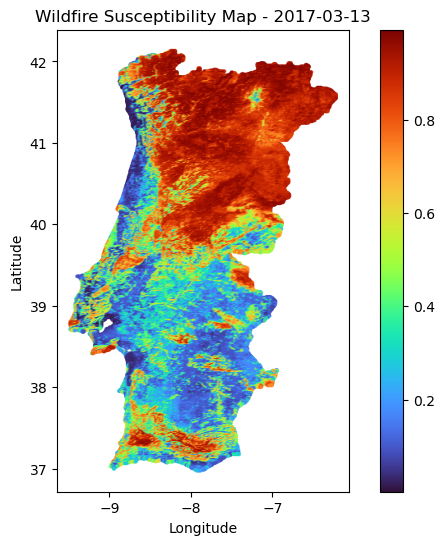

In [48]:
gdf1 = gpd.GeoDataFrame({'susceptibility': susceptibility_map_11}, geometry=geometry, crs="EPSG:3763")  # Include coordinates with appropriate projection in the data frame 
# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
gdf1.plot(column='susceptibility', cmap='turbo', markersize=3, alpha=0.6, legend=True, ax=ax)
ax.set_title("Wildfire Susceptibility Map - 2017-03-13")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Optional save

In [ ]:
# Save calibrated model 
import joblib
joblib.dump(calibrated_rf, 'RF_model_calib.pkl')